In [24]:
from typing import Literal, TypedDict
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain.output_parsers.openai_functions import PydanticOutputFunctionsParser
from langchain_core.utils.function_calling import convert_to_openai_function

import os
from dotenv import load_dotenv
import re


# Load environment variables and set OpenAI API key
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

# Prepare the parser and main types
class ScoreResponse(BaseModel):
    """Get the score response from the response."""

    score: float = Field(description="The numeric score between 0 and 1")
    explanation: str = Field(description="Explanation for the given score")

parser = PydanticOutputFunctionsParser(pydantic_schema=ScoreResponse)

# Define the graph state
class State(TypedDict):
    """Represents the state of the essay grading process."""
    topic: str
    context: str
    essay: str
    level: Literal["high school", "college"]
    weights: dict
    relevance_score: ScoreResponse
    grammar_score: ScoreResponse
    structure_score: ScoreResponse
    depth_score: ScoreResponse
    final_score: ScoreResponse
    current_node: str
    last_score: float
    
# Model reference    
llm = ChatOpenAI(model="gpt-4o-mini")

openai_functions = [convert_to_openai_function(ScoreResponse)]

# Grading functions
def check_relevance(state: State) -> State:
    """Check the relevance of the essay."""
    
    state["current_node"] = "check_relevance"
    prompt = ChatPromptTemplate.from_template(
        "Analyze the relevance of the following essay to the given topic: {topic} "
        "The essay was done in the context of:\n\n{context}"
        "The essay should be in the level of a {level} student."
        "Provide a relevance score between 0 and 1. "
        "Your response should start with a the score followed by the numeric score, "
        "then provide your explanation.\n\nEssay: {essay}"
    )
    try:
        chain = prompt | llm.bind(functions=openai_functions) | parser
        result = chain.invoke({ "essay": state["essay"], "topic": state["topic"], "context": state["context"], "level": state["level"] })
        print (result)
        state["relevance_score"] = result
        state["last_score"] = result.score
    except ValueError as e:
        print(f"Error in check_relevance: {e}")
        state["relevance_score"] = 0.0
    return state


def check_grammar(state: State) -> State:
    """Check the grammar of the essay."""
    
    state["current_node"] = "check_grammar"
    prompt = ChatPromptTemplate.from_template(
        "Analyze the grammar and language usage in the following essay. "
        "Take into account that the essay was done by a {level} student. "
        "Provide a grammar score between 0 and 1. "
        "Your response should start with a the score followed by the numeric score, then provide your explaination. "
        "\n\nEssay: {essay}"
    )
    try:
        chain = prompt | llm.bind(functions=openai_functions) | parser
        result = chain.invoke({ "essay": state["essay"], "level": state["level"] })
        print (result)
        state["grammar_score"] = result
        state["last_score"] = result.score
    except ValueError as e:
        print(f"Error in check_grammar: {e}")
        state["grammar_score"] = 0.0
    return state

def analyze_structure(state: State) -> State:
    """Analyze the structure of the essay."""
    
    state["current_node"] = "analyze_structure"
    prompt = ChatPromptTemplate.from_template(
        "Analyze the structure of the following essay. "
        "Take into account that the essay was done by a {level} student. "
        "Provide a structure score between 0 and 1. "
        "Your response should start with a the score followed by the numeric score, then provide your explaination."
        "\n\nEssay: {essay}"
    )
    chain = prompt | llm.bind(functions=openai_functions) | parser
    try:
        result = chain.invoke({ "essay": state["essay"], "level": state["level"] })
        state["structure_score"] = result
        state["last_score"] = result.score
    except ValueError as e:
        print(f"Error in analyze_structure: {e}")
        state["structure_score"] = 0.0
    return state

def evaluate_depth(state: State) -> State:
    """Evaluate the depth of analysis in the essay."""
    
    state["current_node"] = "evaluate_depth"
    prompt = ChatPromptTemplate.from_template(
        "Evaluate the depth of analysis in the following essay. "
        "Provide a depth score between 0 and 1. "
        "Take into account that the essay was done by a {level} student. "
        "Your response should start with a the score followed by the numeric score, then provide your explaination. "
        "\n\nEssay: {essay}"
    )
    try:
        chain = prompt | llm.bind(functions=openai_functions) | parser
        result = chain.invoke({ "essay": state["essay"], "level": state["level"] })
        state["depth_score"] = result.content
        state["last_score"] = result.score
    except ValueError as e:
        print(f"Error in evaluate_depth: {e}")
        state["depth_score"] = 0.0
    return state

def update_weights(state: State, weights: dict) -> State:
    """Update the weights for the scoring components."""
    
    state["weights"] = weights
    return state

def calculate_final_score(state: State) -> State:
    """Calculate the final score based on individual component scores and user-defined weights."""
    
    state["current_node"] = "calculate_final_score"
    weights = state["weights"]
    total_weight = sum(weights.values())

    final_score = (
        state["relevance_score"].score * weights["relevance"] / total_weight +
        state["grammar_score"].score * weights["grammar"] / total_weight +
        state["structure_score"].score * weights["structure"] / total_weight +
        state["depth_score"].score * weights["depth"] / total_weight
    )

    global_explanation = (
        f"Essay Evaluation Summary:\n\n"
        f"1. Relevance (Weight: {weights['relevance']}):\n"
        f"   Score: {state['relevance_score'].score:.2f}\n"
        f"   {state['relevance_score'].explanation}\n\n"
        f"2. Grammar (Weight: {weights['grammar']}):\n"
        f"   Score: {state['grammar_score'].score:.2f}\n"
        f"   {state['grammar_score'].explanation}\n\n"
        f"3. Structure (Weight: {weights['structure']}):\n"
        f"   Score: {state['structure_score'].score:.2f}\n"
        f"   {state['structure_score'].explanation}\n\n"
        f"4. Depth (Weight: {weights['depth']}):\n"
        f"   Score: {state['depth_score'].score:.2f}\n"
        f"   {state['depth_score'].explanation}\n\n"
        f"Final Score Calculation:\n"
        f"The final score is a weighted average of the above components.\n"
        f"Final Score: {final_score:.2f}\n\n"
        f"Score Breakdown:\n"
        f"- Relevance contribution: {state['relevance_score'].score * weights['relevance'] / total_weight:.2f}\n"
        f"- Grammar contribution: {state['grammar_score'].score * weights['grammar'] / total_weight:.2f}\n"
        f"- Structure contribution: {state['structure_score'].score * weights['structure'] / total_weight:.2f}\n"
        f"- Depth contribution: {state['depth_score'].score * weights['depth'] / total_weight:.2f}\n\n"
        f"Overall Assessment:\n"
        f"This essay received a final score of {final_score:.2f} out of 1.00. "
        f"The score reflects a balanced consideration of the essay's relevance to the topic, "
        f"grammatical correctness, structural coherence, and depth of analysis, "
        f"weighted according to the specified importance of each factor. "
        f"To improve, focus on the areas with lower scores as detailed above."
    )

    state["final_score"] = ScoreResponse(score=final_score, explanation=global_explanation)
    return state


# Initialize the StateGraph
workflow = StateGraph(State)


def grade_essay(topic, context, essay, level, relevance_weight, grammar_weight, structure_weight, depth_weight):
    state = State(
        topic=topic,
        context=context,
        essay=essay,
        level=level,
        weights={
            "relevance": relevance_weight,
            "grammar": grammar_weight,
            "structure": structure_weight,
            "depth": depth_weight
        },
        relevance_score={},
        grammar_score={},
        structure_score={},
        depth_score={},
        final_score={}
    )
    
    for output in app.stream(state):
        if output['final_score'].score is not None:
            return f"Score: {output['final_score'].score:.2f}\n\nExplanation:\n{output['final_score'].explanation}"
    
    return "Error: Failed to generate a score."


# Add nodes to the graph
workflow.add_node("check_relevance", check_relevance)
workflow.add_node("check_grammar", check_grammar)
workflow.add_node("analyze_structure", analyze_structure)
workflow.add_node("evaluate_depth", evaluate_depth)
workflow.add_node("calculate_final_score", calculate_final_score)

# Define and add conditional edges
workflow.add_edge(
    "check_relevance",
    "check_grammar",
)
workflow.add_edge(
    "check_grammar",
    "analyze_structure",
)
workflow.add_edge(
    "analyze_structure",
    "evaluate_depth"
)
workflow.add_edge(
    "evaluate_depth",
    "calculate_final_score"
)

# Set the entry point
workflow.set_entry_point("check_relevance")

# Set the exit point
workflow.add_edge("calculate_final_score", END)

# Compile the graph
app = workflow.compile()

In [12]:
app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'check_relevance': Node(id='check_relevance', name='check_relevance', data=check_relevance(func_accepts_config=False, afunc_accepts_config=False, tags=None, recurse=True), metadata=None), 'check_grammar': Node(id='check_grammar', name='check_grammar', data=check_grammar(func_accepts_config=False, afunc_accepts_config=False, tags=None, recurse=True), metadata=None), 'analyze_structure': Node(id='analyze_structure', name='analyze_structure', data=analyze_structure(func_accepts_config=False, afunc_accepts_config=False, tags=None, recurse=True), metadata=None), 'evaluate_depth': Node(id='evaluate_depth', name='evaluate_depth', data=evaluate_depth(func_accepts_config=False, afunc_accepts_config=False, tags=None, recurse=True), metadata=None), 'calculate_final_score': Node(id='calculate_final_score', name='calculate_final_score', data=calculate_final_s

In [25]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_png()))
except ImportError:
    print("You likely need to install dependencies for pygraphviz, see more here https://github.com/pygraphviz/pygraphviz/blob/main/INSTALL.txt")

You likely need to install dependencies for pygraphviz, see more here https://github.com/pygraphviz/pygraphviz/blob/main/INSTALL.txt


In [5]:
%%capture --no-stderr
%pip install --quiet pyppeteer
%pip install --quiet nest_asyncio

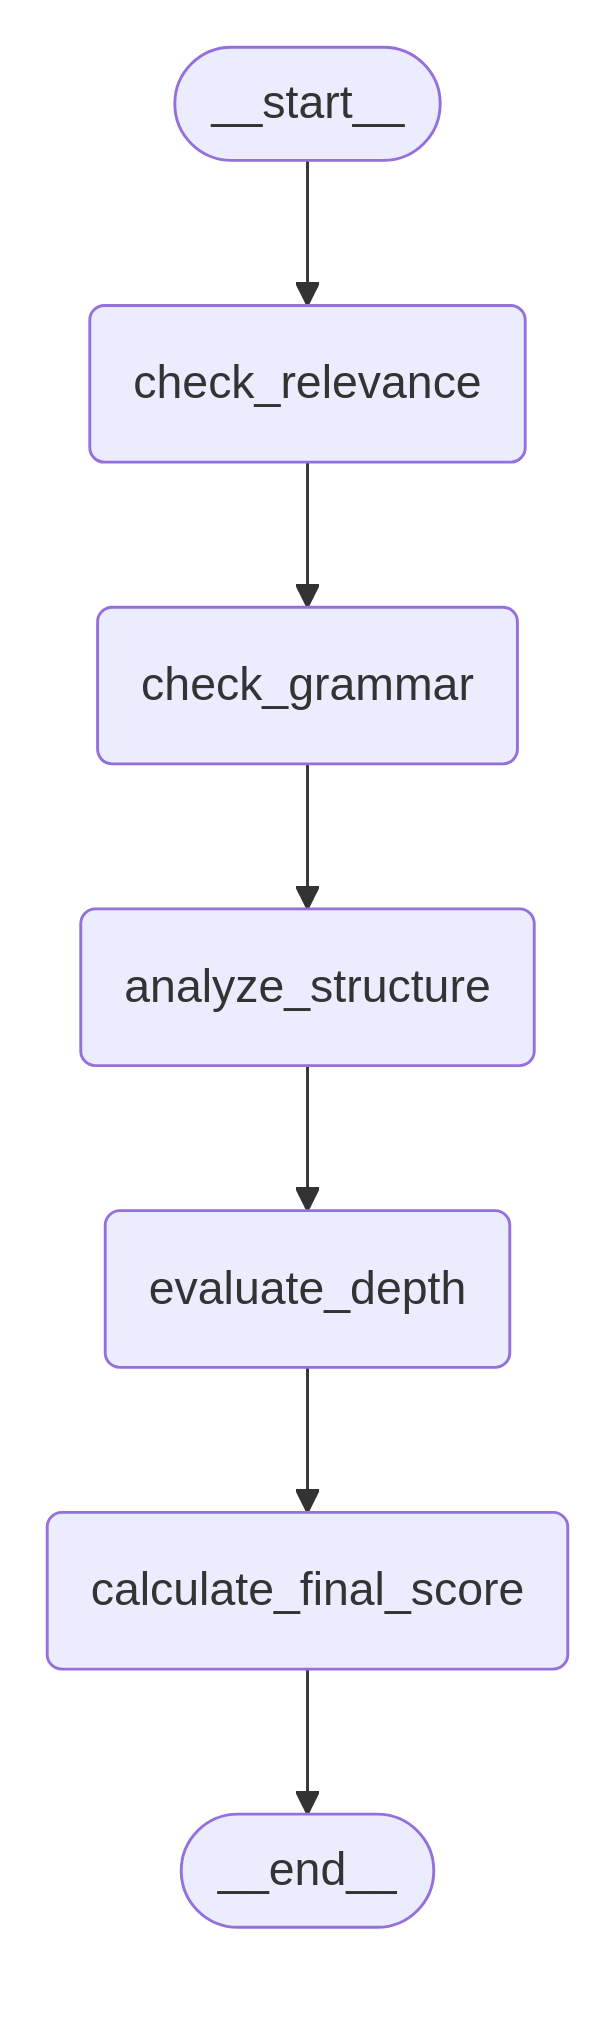

In [26]:

import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
nest_asyncio.apply()  # Required for Jupyter Notebook to run async functions

display(
    Image(
        app.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)